In [ ]:
# Copyright (c) 2022, Arm Limited and Contributors
#
# SPDX-License-Identifier: Apache-2.0
#
# Licensed under the Apache License, Version 2.0 the "License";
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [2]:
def separable_conv(x, filters, dilations):
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.DepthwiseConv2D((3, 3), strides=(1, 1), dilation_rate=dilations, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters, (1, 1), strides=(1, 1), dilation_rate=(1, 1), padding='valid')(x)
    return x

def residual_block(x):
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(8, (3, 3), strides=(2, 2), dilation_rate=(1, 1), padding='same')(x)
    x1 = separable_conv(x, 8, (1, 1))
    x = tf.keras.layers.Add()([x, x1])
    x1 = separable_conv(x, 8, (2, 2))
    x = tf.keras.layers.Add()([x, x1])
    x1 = separable_conv(x, 8, (1, 1))
    x = tf.keras.layers.Add()([x, x1])
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1), dilation_rate=(1, 1), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), dilation_rate=(1, 1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

def create_style_transfer_model():
    input = tf.keras.Input(shape=(512, 256, 3), batch_size=1, name='input')
    
    x = tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1), dilation_rate=(1, 1), padding='same')(input)
    x1 = residual_block(x)
    x = tf.keras.layers.Add()([x, x1])
    x1 = residual_block(x)
    x = tf.keras.layers.Add()([x, x1])
    x1 = separable_conv(x, 16, (1, 1))
    x = tf.keras.layers.Add()([x, x1])
    
    output = tf.keras.layers.Conv2D(3, (3, 3), strides=(1, 1), dilation_rate=(1, 1), padding='same')(x)

    model = tf.keras.Model(inputs=[input], outputs=[output], name='style_transfer')
    return model

model = create_style_transfer_model()

In [3]:
model.summary()

Model: "style_transfer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(1, 512, 256, 3)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (1, 512, 256, 16)    448         ['input[0][0]']                  
                                                                                                  
 re_lu (ReLU)                   (1, 512, 256, 16)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (1, 256, 128, 8)     1160        ['re_lu[0][0]']                  
                                                                                     

 conv2d_9 (Conv2D)              (1, 256, 128, 8)     72          ['depthwise_conv2d_5[0][0]']     
                                                                                                  
 add_6 (Add)                    (1, 256, 128, 8)     0           ['add_5[0][0]',                  
                                                                  'conv2d_9[0][0]']               
                                                                                                  
 re_lu_9 (ReLU)                 (1, 256, 128, 8)     0           ['add_6[0][0]']                  
                                                                                                  
 conv2d_10 (Conv2D)             (1, 256, 128, 16)    1168        ['re_lu_9[0][0]']                
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (1, 512, 256, 16)   1040        ['conv2d_10[0][0]']              
 spose)   

In [4]:
def show_image(image):
    image = np.squeeze(image)
    plt.figure()
    plt.imshow(image / 255.0) 
    plt.show() 

def load_image(filename) :
    image = Image.open(filename)
    image.load()
    data = np.asarray(image, dtype="int32")
    data = data[:,:,:3]
    data = data.astype('float32')
    return data

def load_image_directory(directory_path):
    images = []
    for image_path in os.listdir(directory_path):
        full_path = os.path.join(directory_path, image_path)
        image = load_image(full_path)
        images.append(image)
    return np.array(images, 'float32') 

In [5]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.MeanSquaredError())

In [6]:
x = load_image_directory('dataset/x')
y = load_image_directory('dataset/y')

In [7]:
model.fit(x, y, batch_size=1,  epochs=100, validation_split=0.2)

Epoch 1/100
80/80 [==============================] - 13s 61ms/step - loss: 6036.3032 - val_loss: 4376.2310
Epoch 2/100
80/80 [==============================] - 5s 56ms/step - loss: 4478.7441 - val_loss: 3643.6099
Epoch 3/100
80/80 [==============================] - 5s 57ms/step - loss: 4034.1479 - val_loss: 3203.6011
Epoch 4/100
80/80 [==============================] - 5s 58ms/step - loss: 4002.1431 - val_loss: 3298.5913
Epoch 5/100
80/80 [==============================] - 5s 59ms/step - loss: 3629.6902 - val_loss: 2488.7939
Epoch 6/100
80/80 [==============================] - 5s 57ms/step - loss: 2912.3560 - val_loss: 2706.3301
Epoch 7/100
80/80 [==============================] - 5s 58ms/step - loss: 2999.0718 - val_loss: 2381.1130
Epoch 8/100
80/80 [==============================] - 5s 58ms/step - loss: 2768.9116 - val_loss: 2304.8245
Epoch 9/100
80/80 [==============================] - 5s 58ms/step - loss: 2440.9380 - val_loss: 1778.2109
Epoch 10/100
80/80 [=========================

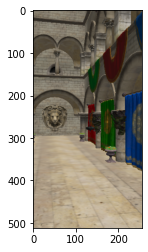

In [8]:
test_input = x[0][np.newaxis, ...]
show_image(test_input)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


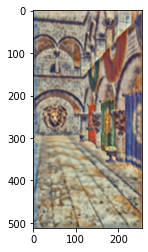

In [9]:
pred = model.predict(test_input)
show_image(pred)

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('style_transfer.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\pavrud01\AppData\Local\Temp\tmpmow3j78i\assets


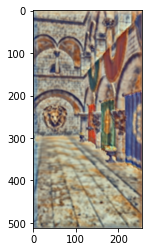

In [12]:
interpreter = tf.lite.Interpreter(model_path="style_transfer.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
input_data = test_input
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

pred = interpreter.get_tensor(output_details[0]['index'])
show_image(pred)